In [11]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [12]:
df = pd.read_csv('./data/lalonde.csv')
df

,Unnamed: 0,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,5,1,33,8,1,0,0,1,0.0,0.0,289.7899
...,...,...,...,...,...,...,...,...,...,...,...
609,610,0,18,11,0,0,0,1,0.0,0.0,10150.5000
610,611,0,24,1,0,1,1,1,0.0,0.0,19464.6100
611,612,0,21,18,0,0,0,0,0.0,0.0,0.0000
612,613,0,32,5,1,0,1,1,0.0,0.0,187.6713


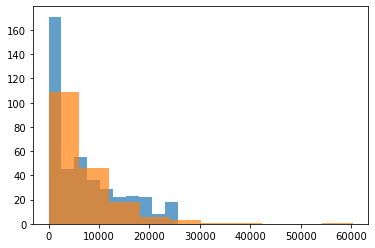

In [13]:
plt.hist(df[df['treat']==0]['re78'], alpha=0.7)
plt.hist(df[df['treat']==1]['re78'], alpha=0.7)
plt.show()

In [14]:
def exact_mc_perm_test(xs, ys, nmc):
    n, k = len(xs), 0
    diff = np.abs(np.mean(xs) - np.mean(ys))
    zs = np.concatenate([xs, ys])
    for j in range(nmc):
        np.random.shuffle(zs)
        k += diff < np.abs(np.mean(zs[:n]) - np.mean(zs[n:]))
    return k / nmc

In [15]:
exact_mc_perm_test(
    df[df['treat']==0]['re78'], 
    df[df['treat']==1]['re78'], 
    300000)

0.3343333333333333

In [16]:
import scipy.stats as st
st.ttest_ind(
    df[df['treat']==0]['re78'],
    df[df['treat']==1]['re78'], 
    equal_var=True)

Ttest_indResult(statistic=0.9663522254463778, pvalue=0.3342496685909654)

#### Tips
 - Even though distribution of samples is not normally distributed and we can assume that the distribution of population would not follow normal distribution, the result p-value of t-test and permutation test became almost same why?
 - t-test assumptions of distribution normality is not the assumption for population distribution, it is assumption for the means of different samples distribution.
 - For each(t=0/1) group we have more than 30 samples, we can assume that means of samples would follow normal distribution due to central limit theorem.
 - In this sense, if we have enough samples (more than 30 samples), then we can forget about the shape of the distribution. And this is why the results of t-test and permutation test became same.

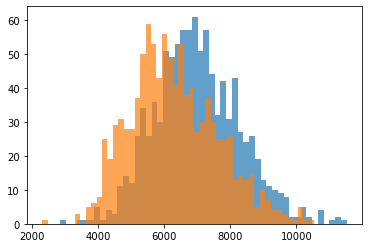

In [17]:
mean_treat_group = []
mean_nontreat_group = []

for i in range(1000):
    mean_nontreat_group.append(df[df['treat'] == 0].sample(30)['re78'].mean())
    mean_treat_group.append(df[df['treat'] == 1].sample(30)['re78'].mean())
    
plt.hist(mean_nontreat_group, alpha=0.7, bins=50)
plt.hist(mean_treat_group, alpha=0.7, bins=50)
plt.show()

#### Validation
 - I tried to sample more than 30 and checked distribution above. It shows CLT is right.
 - But another context - we are trying to test for difference - variance is too big now so it is sure that we need more samples. * When alpha = 0.05, it is obvious that 1-beta < 0.8!

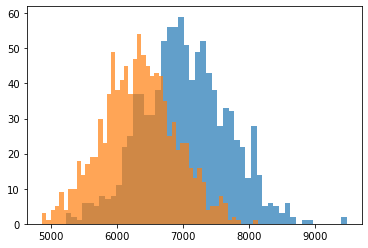

In [18]:
mean_treat_group = []
mean_nontreat_group = []

for i in range(1000):
    mean_nontreat_group.append(df[df['treat'] == 0].sample(100)['re78'].mean())
    mean_treat_group.append(df[df['treat'] == 1].sample(100)['re78'].mean())
    
plt.hist(mean_nontreat_group, alpha=0.7, bins=50)
plt.hist(mean_treat_group, alpha=0.7, bins=50)
plt.show()

#### Validation2
 - We increased samples up to 100, then variance decreased. In this case, when alpha = 0.05, 1-beta becomes larger.

In [19]:
import scipy.stats as st
res_ttest = st.ttest_ind(
                mean_nontreat_group,
                mean_treat_group, 
                equal_var=True)
res_perm = exact_mc_perm_test(
                mean_nontreat_group, 
                mean_treat_group, 
                300000)
print(res_ttest)
print(res_perm)

Ttest_indResult(statistic=26.20543069243731, pvalue=2.349975385046009e-130)
0.0


### Cautions!
 - If you want to t-test with mean_nontreat_group / mean_treat_group, you can't use their sample variance.

In [20]:
import statsmodels.api as sm
X = df[['treat']]
X = sm.add_constant(X)
model = sm.OLS(
    df['re78'],
    X
)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   re78   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9338
Date:                Thu, 14 Apr 2022   Prob (F-statistic):              0.334
Time:                        22:49:47   Log-Likelihood:                -6346.4
No. Observations:                 614   AIC:                         1.270e+04
Df Residuals:                     612   BIC:                         1.271e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6984.1697    360.710     19.362      0.000    6275.791    7692.549
treat       -635.0262    657.137     -0.966      0.334   -1925.544     655.492
==============================================================================
Omnibus:                      209.619   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              775.567
Skew:                           1.567   Prob(JB):                    3.87e-169
Kurtosis:                       7.527   Cond. No.                         2.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Sanity checking
 - Before treatment(re75), the average income of t=0 grp and t=1 grp should be same
 - Before treatment(re75), the variance income of t=0 grp and t=1 grp should be same
 - Bias for covariate should not exist between t=0/1 clustering
     - if not, it should be smoothed by propensity score